## Introduction to the SAMPLED BASED DIAGONALIZATION

In [2]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

In [109]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'


In [110]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [6.95922269e-18]
dimension= 640


#### Select the samples

In [111]:
prob=np.conjugate(psi0[:,0])*psi0[:,0]

In [112]:

n_instances=20
bins=int(0.5*NSMHamiltonian.hamiltonian.shape[0])
print(bins)
selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances,replace=False,p=prob)
print(selection)
effective_hamiltonian=lil_matrix((n_instances,n_instances))

for a,idx_a in enumerate(selection):
    for b,idx_b in enumerate(selection):
        effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]


effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')

print(effective_egs)


320
[114 549  35 182 233 383 477  17 185 191  26 100 485 108 121 496 352 592
 386 136]
[-30.70619489]


[5.85913437e-35 1.36882518e-04 2.73765037e-04 4.10647555e-04
 5.47530073e-04 6.84412591e-04 8.21295110e-04 9.58177628e-04
 1.09506015e-03 1.23194266e-03 1.36882518e-03 1.50570770e-03
 1.64259022e-03 1.77947274e-03 1.91635526e-03 2.05323777e-03
 2.19012029e-03 2.32700281e-03 2.46388533e-03 2.60076785e-03
 2.73765037e-03 2.87453288e-03 3.01141540e-03 3.14829792e-03
 3.28518044e-03 3.42206296e-03 3.55894547e-03 3.69582799e-03
 3.83271051e-03 3.96959303e-03 4.10647555e-03 4.24335807e-03
 4.38024058e-03 4.51712310e-03 4.65400562e-03 4.79088814e-03
 4.92777066e-03 5.06465318e-03 5.20153569e-03 5.33841821e-03
 5.47530073e-03 5.61218325e-03 5.74906577e-03 5.88594828e-03
 6.02283080e-03 6.15971332e-03 6.29659584e-03 6.43347836e-03
 6.57036088e-03 6.70724339e-03 6.84412591e-03 6.98100843e-03
 7.11789095e-03 7.25477347e-03 7.39165599e-03 7.52853850e-03
 7.66542102e-03 7.80230354e-03 7.93918606e-03 8.07606858e-03
 8.21295110e-03 8.34983361e-03 8.48671613e-03 8.62359865e-03
 8.76048117e-03 8.897363

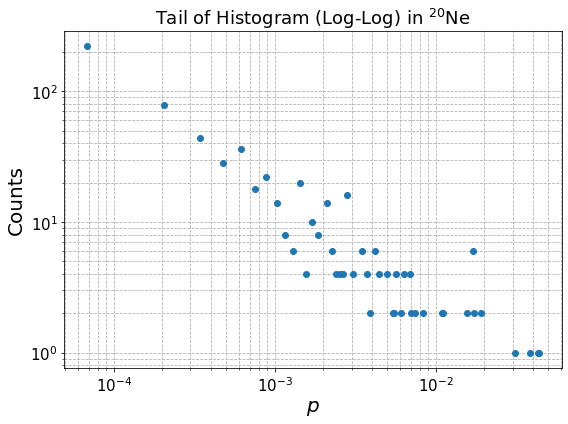

In [113]:




# Compute histogram (don't plot yet)
counts, bin_edges = np.histogram(prob, bins=bins,density=False)

print(bin_edges)
# Bin centers (x-axis)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Filter out zero counts to avoid log(0)
nonzero = counts > 0
counts = counts[nonzero]

print(counts)

bin_centers = bin_centers[nonzero]
bin_widths = np.diff(bin_edges)

print(bin_centers)

pdf = counts #/ (np.sum(counts))

# Plot in log-log scale
plt.figure(figsize=(8,6))
plt.loglog(bin_centers, pdf, marker='o', linestyle='none')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.title(r"Tail of Histogram (Log-Log) in "+title, fontsize=18)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [ ]:
e_values=[]
errors=[]
nbatches=10
for i in range(pdf.shape[0]):
    n_instances=np.sum(counts[-i-1:])
    print(n_instances)
    e_ave=0.
    for r in range(nbatches):
        
        selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances,replace=False,p=prob)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        #print(effective_hamiltonian.shape)
        if effective_hamiltonian.shape[0]==1:
            effective_egs=NSMHamiltonian.hamiltonian.tocsr()[selection,selection][0,0]

        else:
            effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
            effective_egs=effective_egs[0]



        e_ave+=effective_egs
    e_ave=e_ave/nbatches
    error=np.abs(e_ave-egs[0])/np.abs(egs[0])
    errors.append(error)
    e_values.append(e_ave)


1
2
3
4
6
8
14
16
18
20
22
24
26
30
34
36
40
42
44
48
52
58
60
64
70
74
90
94
98
102
108
122
130
140
144
164
170
178
192
214
232
268
296
340
418
640


[np.float64(0.46300125476289217), array([0.41210939]), array([0.36864353]), array([0.31038282]), array([0.31555942]), array([0.30762969]), array([0.27506715]), array([0.28871006]), array([0.26958713]), array([0.27673195]), array([0.26077653]), array([0.25944095]), array([0.26349886]), array([0.24996151]), array([0.24771677]), array([0.23948189]), array([0.23545718]), array([0.24002789]), array([0.23676756]), array([0.22900404]), array([0.22465024]), array([0.21419819]), array([0.21022029]), array([0.20251888]), array([0.19706222]), array([0.18897637]), array([0.17380823]), array([0.17439391]), array([0.16291393]), array([0.15462782]), array([0.15292105]), array([0.14106206]), array([0.13159952]), array([0.11990901]), array([0.11990429]), array([0.10791585]), array([0.09919425]), array([0.09688074]), array([0.08715251]), array([0.07169744]), array([0.06128587]), array([0.04724199]), array([0.03758543]), array([0.02446945]), array([0.00994666]), array([0.])]


ValueError: Input could not be cast to an at-least-1D NumPy array

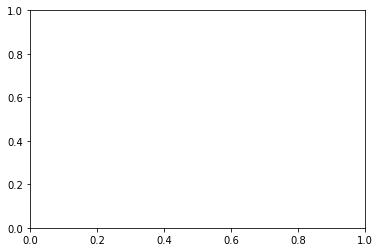

In [123]:

print(errors)
plt.plot(errors)
plt.show()

errors.reverse()
e_values.reverse()

errors=np.asarray(errors)
e_values=np.asarray(e_values)


-10.017185927392056
Fitted power law: y ≈ 0.000045 * x^(-1.633)
R² = 0.9152


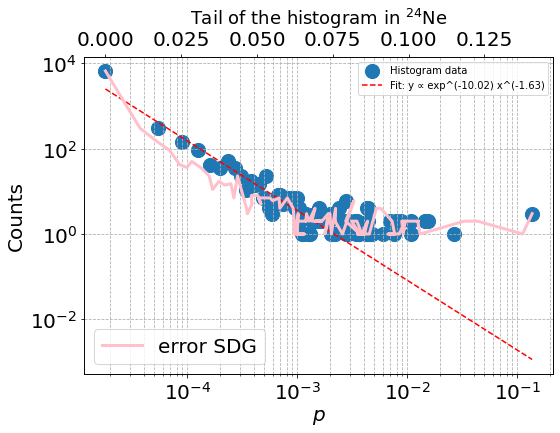

In [108]:
from scipy import stats
mask = counts > 0
x = bin_centers[mask]
y = counts[mask]

# Take logs
logx = np.log(x[x<10**-3])
logy = np.log(y[x<10**-3])

# Fit linear regression in log-log space
slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

# Extract power-law parameters
b = -slope
a = np.exp(intercept)
print(intercept)
print(f"Fitted power law: y ≈ {a:.6f} * x^(-{b:.3f})")
print(f"R² = {r_value**2:.4f}")

# Plot
fig,ax=plt.subplots(figsize=(8,6))

ax_twin=ax.twiny()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r"Tail of the histogram in "+title, fontsize=18)
ax.scatter(x, y,  label='Histogram data',s=200)
ax.loglog(x, a * x**(-b), 'r--', label=f'Fit: y ∝ exp^({np.log(a):.2f}) x^(-{b:.2f})')
ax.set_xlabel(r'$p$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(labelsize=20)
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
ax_twin.plot(errors,counts,color='pink',linewidth=3,linestyle='-',label='error SDG')
ax_twin.set_ylabel('relative error(SDG)',fontsize=20)
ax_twin.legend(fontsize=20,loc='lower left')
ax_twin.tick_params(labelsize=20)
plt.show()

#### Build-up an algorithm to save the number of instances with a fixed accuracy

Hyperparameters

In [ ]:
nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6),(10,8)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si',r'$^{32}$Ar']

history={}
errors=[]
n_instances_max=[]

for r,title in enumerate(titles):
    print('title=',title)
    nparticles_a=nparts[r][0]
    nparticles_b=nparts[r][1]
    
    history[nparts[r]]=[]
    
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

    print(egs)

    print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
    #print('j_value=',J2Class.j_value(psi0))
    print('dimension=',NSMHamiltonian.hamiltonian.shape[0])
    
    prob=np.conjugate(psi0[:,0])*psi0[:,0]
    
    n_instances=np.arange(2,prob.shape[0])
    
    error=1000
    i=0
    while(error> 10**-3):
        selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances[i],replace=False,p=prob)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        
        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        error=np.abs(effective_egs[0]-egs[0])/np.abs(egs[0])
        history[nparts[r]].append(error)
        
        i+=1
    
    n_instances_max.append(i)
    errors.append(error)
    print('\n')
    print(n_instances[i])
    print('error=',np.abs(effective_egs[0]-egs[0])/np.abs(egs[0]),'\n')     
    
    

#### Analysis of the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data=np.load('data/samplebaseddiagonalization_data/run_1%.npz')

errors=data['errors']
titles=data['titles']
history=data['history']
n_instances=data['n_instances']
dimensions=data['dimensions']

print(titles)
# 0 5 9 12
selection=[0,5,9,12]
print(titles[selection])

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell',fontsize=30)
plt.ylabel('n instances',fontsize=30)
plt.bar(np.arange(n_instances.shape[0]),dimensions)
plt.bar(np.arange(n_instances.shape[0]),n_instances)
#plt.semilogy()
plt.xticks(np.arange(n_instances.shape[0]),titles[:n_instances.shape[0]])
#plt.text(x=1,y=80000,s=r'$H=\sum_a e_a c^{+}_a c_a +\frac{1}{4}\sum_{abcd} v_{abdc} c^{+}_a c^{+}_b c_c c_d$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell (1% accuracy energy)',fontsize=30)
plt.ylabel(r'$N_s$',fontsize=30)
plt.xlabel(r'$\dim$',fontsize=30)

plt.scatter(dimensions,dimensions)
plt.plot(dimensions,dimensions)
plt.scatter(dimensions,n_instances)
plt.loglog()

plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.scatter(n_instances,dimensions)
plt.loglog()
plt.show()

from scipy import stats

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming these are your data
# dimensions = ...
# n_instances = ...

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")

# Plot original data and the fitted curve
plt.figure(figsize=(8,6))
plt.scatter(dimensions, n_instances, label='Data', color='blue')

# Create smooth line for fitted curve
x_fit = np.linspace(min(dimensions), max(dimensions), 200)
y_fit = a * x_fit**b
plt.plot(x_fit, y_fit, label=f'Fit: y ≈ {a:.2f} * x^{b:.2f}', color='red', linestyle='--')

# Log scales
plt.xscale('log')
plt.yscale('log')

# Labels
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
